## 01 Ridership Time Series Forecasting Model
This notebook builds a machine learning time series forecasting model to predict demand of the Boston Bluebikes bikeshare system. Unlike other machine learning problems, time series models must use validation data that occurs *after* the training data.

### Notebook Objectives
1. Process zip files to extract all trip data from 2015 to present.
2. Pickle the processed trips dataframe for future operations.
3. Build a ML time series model by modeling signal drift, seasonality, and residual noise.

In [2]:
from pathlib import Path
from zipfile import ZipFile
import pandas as pd
from pandas.plotting import autocorrelation_plot
import datetime
import logging
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn import base
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, cross_validate
import dill

logging.basicConfig(filename='preprocess.log', filemode='w', 
        level=logging.DEBUG, force=True,
        format='%(asctime)s %(levelname)s:%(message)s')

In [36]:
# Extract trips data from https://s3.amazonaws.com/hubway-data/index.html
for path in Path('./data/').glob('*.zip'):
    with ZipFile(path, mode="r") as z:
        z.extractall(Path('./data/extracted/'))

In [37]:
# Generate dataframe with trips data
trips = pd.DataFrame()
for path in Path('./data/extracted/').glob('*.csv'):
    logging.info(f'Processing {path}')
    trips = pd.concat([trips, pd.read_csv(path)])

# Pickle results
trips.to_pickle(Path('./assets/trips_df.pkl'))

In [4]:
# Load pickled dataframe (2.6 GB! Lots of data here)
trips = pd.read_pickle(Path('./assets/trips_df.pkl'))

In [61]:
# Inspect data
print(f'Shape: {trips.shape}')

Shape: (16868559, 16)


Over 16 million observations here! That's a lot of bike trips from 2015 to 2023.

In [6]:
# Inspect columns and datatypes
trips.dtypes

tripduration                 int64
starttime                   object
stoptime                    object
start station id             int64
start station name          object
start station latitude     float64
start station longitude    float64
end station id              object
end station name            object
end station latitude        object
end station longitude       object
bikeid                       int64
usertype                    object
postal code                 object
birth year                  object
gender                     float64
dtype: object

In [7]:
# Convert to datetime
trips['starttime'] = pd.to_datetime(trips['starttime'], format='%Y-%m-%d')
trips['stoptime'] = pd.to_datetime(trips['stoptime'], format='%Y-%m-%d')

In [8]:
# Get daily trip counts
counts = trips.groupby(by=[trips['starttime'].dt.date], 
                             as_index=True).agg(count=('tripduration', 'count'))
counts.index = pd.Index(counts.index).rename('date')
counts.index = pd.to_datetime(counts.index, format='%Y-%m-%d')

# Pickle results
counts.to_pickle(Path('./assets/counts_df.pkl'))

In [9]:
# Load pickled dataframe
counts = pd.read_pickle(Path('./assets/counts_df.pkl'))

In [10]:
# Inspect number of observations after groupby operation
print(counts.shape)
counts.head()

(2947, 1)


,count
date,
2015-01-01,127
2015-01-02,213
2015-01-03,142
2015-01-04,112
2015-01-05,337


In [12]:
# Test-train split. This notebook uses a single fold (see other notebooks for other approaches)
train = counts[:int(len(counts)*0.8)].squeeze()
valid = counts[int(len(counts)*0.8):].squeeze()

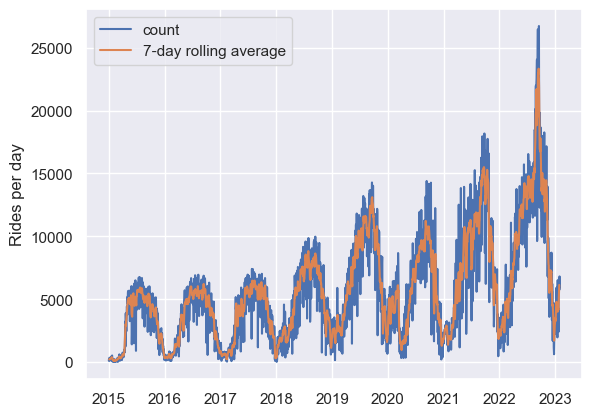

In [13]:
# Plot number of rides over the years
plt.plot(counts, label='count')
plt.plot(counts.rolling(window=7, center=True).mean(), label='7-day rolling average')
# plt.xlim(datetime.date(2016, 1, 1), datetime.date(2018, 1, 1))
plt.ylabel('Rides per day');
plt.legend();

### Modeling Drift
From the plot of daily rides over time, it appears that the rate of growth isn't quite linear but perhaps more quadratic. Let's create a custom transformer that converts the time into days and generates $t$ and $t^2$ features.

Training score: 0.1720779812238704
Validation score: -0.42737693839074176


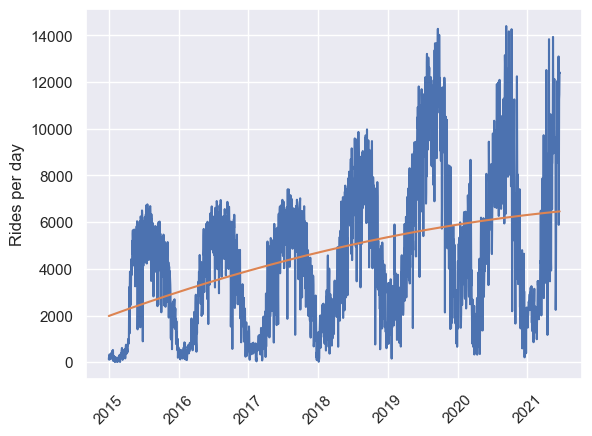

In [14]:
# TODO Does an index selector simplify things?
# class IndexSelector(base.BaseEstimator, base.TransformerMixin):
#     """Return indices of data frame or Series for use in other estimators."""
    
#     def fit(self, X, y=None):
#         return self
    
#     def transform(self, X):
#         return X.index

class QuadBackground(base.BaseEstimator, base.TransformerMixin):
    """Convert datetime to days and generate t and t^2 features"""
    
    def fit(self, X, y=None):
        self.X0 = X[0]
        return self
    
    def transform(self, X):
        days = (X - self.X0).days
        return np.c_[days, days**2]

# drift = Pipeline([('indices', IndexSelector()),
#                   ('drift', QuadBackground()),
#                   ('regressor', Ridge())])
drift = Pipeline([('drift', QuadBackground()),
                  ('regressor', Ridge())])

drift.fit(train.index, train)

plt.plot(train.index, train.values,
         train.index, drift.predict(train.index))
plt.xticks(rotation=45);
plt.ylabel('Rides per day');

# Metrics
print(f'Training score: {drift.score(train.index, train)}')
print(f'Validation score: {drift.score(valid.index, valid)}')

### Modeling Seasonality
Let's find the frequencies of the seasonality in the signal using an FFT.

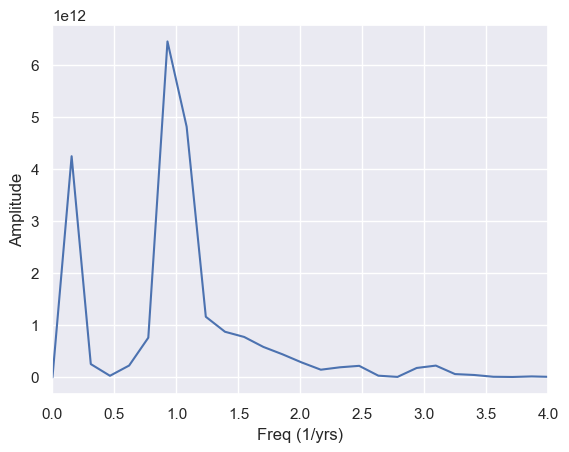

In [15]:
# Fourier transforms
fft_daily = np.fft.fft(train - train.mean())
yrs = (train.index[-1] - train.index[0]).days / 365.

plt.plot(np.arange(len(fft_daily)) / yrs, np.abs(fft_daily)**2)
plt.xlim(0, 4)
plt.xlabel('Freq (1/yrs)');
plt.ylabel('Amplitude');

There is a defined peak at 1/year denoting a yearly cycle. Since time is measured in days here, the corresponding period is 365 days. There is also a noteable 5 year cycle (0.2/year or period of 365*5 days). At first pass this cycle does not seem to have an obvious physical meaning in reality and instead is believed to be an artifact from the limited number of years in the dataset.

We can next model seasonality as sinusoidal with a single Fourier series term:

$$ f(t) = A \sin\frac{2\pi t}{P} + B\cos\frac{2\pi t}{P} + f_0 \ . $$

Where P is the period and the coefficients $A$, $B$, and $f_0$ are fit with linear regression.

Training score: 0.6899445854301884
Validation score: 0.36635733401792425


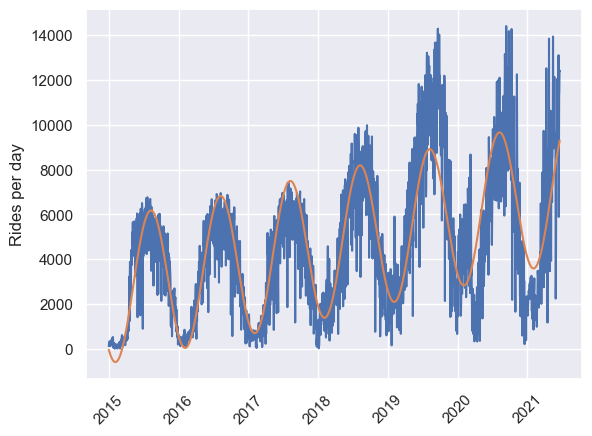

In [16]:
class FourierComponents(base.BaseEstimator, base.TransformerMixin):
    '''Return single Fourier term based on signal period'''

    def __init__(self, period):
        self.period = period
    
    def fit(self, X, y=None):
        self.X0 = X[0]
        return self
    
    def transform(self, X):
        dt = (X - self.X0).days * 2 * np.pi / self.period
        return np.c_[np.sin(dt), np.cos(dt)]

union = FeatureUnion([('drift', QuadBackground()),
                      ('fourier_1yr', FourierComponents(365))])

model_drift_fourier = Pipeline([('union', union),
                                ('regressor', Ridge())])

model_drift_fourier.fit(train.index, train)

# Visualize results
plt.plot(train.index, train, 
         train.index, model_drift_fourier.predict(train.index));
plt.xticks(rotation=45);
plt.ylabel('Rides per day');     

# Metrics check
print(f'Training score: {model_drift_fourier.score(train.index, train)}')
print(f'Validation score: {model_drift_fourier.score(valid.index, valid)}')

### Modeling Weekly Cycles
A Fourier term could also be used to model the weekly cycle, but in many cases a categorical feature works better to capture the weekday vs. weekend differences.

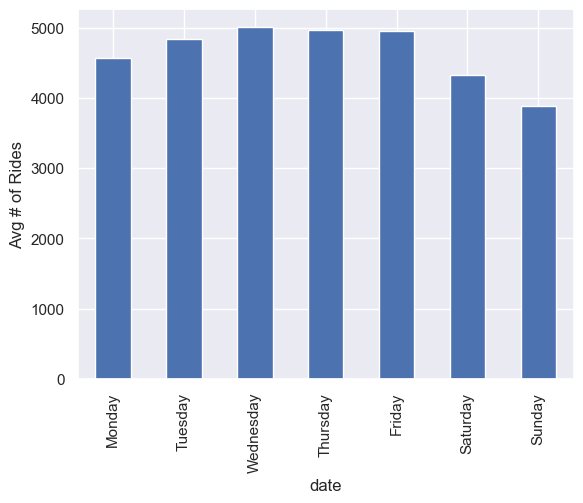

In [17]:
# Visualize weekly cycle
days = train.groupby(train.index.dayofweek).mean().plot(kind='bar')
plt.xticks(range(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']);
plt.ylabel('Avg # of Rides');

Weekly activity is not exactly sinusoidal, so let's proceed with modeling it as a categorical feature. We'll use one-hot encoding for the day of the week.

Training score: 0.7054489994404537
Validation score: 0.3626701646693512


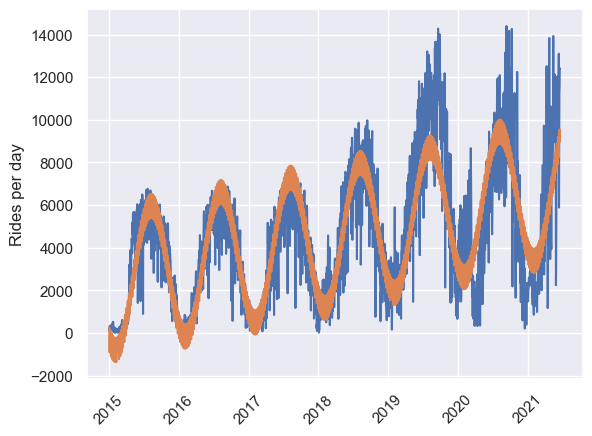

In [18]:
class DayofWeek(base.BaseEstimator, base.TransformerMixin):
    '''One-hot encode day of week as categorical feature'''
    
    def fit(self, X, y=None):
        return self
    
    def day_vector(self, day):
        v = np.zeros(7)
        v[day] = 1
        return v
    
    def transform(self, X):
        return np.stack([self.day_vector(d) for d in X.dayofweek])

union = FeatureUnion([('drift', QuadBackground()),
                      ('fourier_1yr', FourierComponents(365)),
                      ('dayofweek', DayofWeek())])
                      
model_drift_seasonality = Pipeline([('union', union),
                                    ('regressor', Ridge())])

model_drift_seasonality.fit(train.index, train)

# Visualize results
plt.plot(train.index, train, 
         train.index, model_drift_seasonality.predict(train.index));
plt.xticks(rotation=45);
plt.ylabel('Rides per day');

# Metrics check
print(f'Training score: {model_drift_seasonality.score(train.index, train)}')
print(f'Validation score: {model_drift_seasonality.score(valid.index, valid)}')

### Feature Engineering
Let's try adding additional features related to weather to see if it improves the model. Weather data was obtained from [NOAA](https://www.ncei.noaa.gov/cdo-web/) for Boston Logan International Airport.

In [20]:
# Import weather data
weather = pd.read_csv(Path('./assets/noaa_weather_BOS.csv'))
weather['DATE'] = pd.to_datetime(weather['DATE'], format='%Y-%m-%d')
weather.head(3)

,STATION,NAME,DATE,AWND,PGTM,PRCP,SNOW,TAVG,TMAX,TMIN,...,WSF2,WSF5,WT01,WT02,WT03,WT04,WT05,WT06,WT08,WT09
0,USW00014739,"BOSTON LOGAN INTERNATIONAL AIRPORT, MA US",2015-01-01,14.32,NaN,0.00,0.0,26,33,22,...,23.0,29.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USW00014739,"BOSTON LOGAN INTERNATIONAL AIRPORT, MA US",2015-01-02,12.75,NaN,0.00,0.0,34,41,31,...,25.9,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,USW00014739,"BOSTON LOGAN INTERNATIONAL AIRPORT, MA US",2015-01-03,10.29,NaN,0.62,1.4,28,37,22,...,21.9,25.1,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN


In [22]:
features = counts.merge(weather[['DATE', 'AWND', 'PRCP', 'SNOW', 'TAVG']], 
                   left_on='date', right_on='DATE', how='inner').set_index('DATE').fillna(method='bfill')
features.head()

# Pickle results
features.to_pickle(Path('./assets/features_df.pkl'))

In [23]:
train = features[:int(len(counts)*0.8)].squeeze()
valid = features[int(len(counts)*0.8):].squeeze()

Training R^2: 0.7612292257384539
Validation R^2: 0.40911600385808466
Training RMSE: 1538.1491956726748
Validation RMSE: 3949.1279234633384


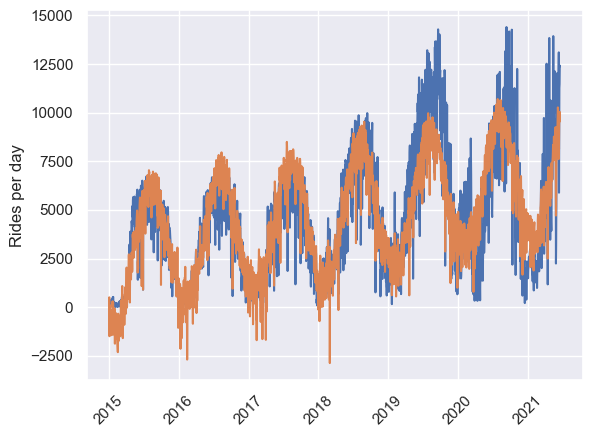

In [25]:
class IndexSelector(base.BaseEstimator, base.TransformerMixin):
    """Return indices of dataframe or Series for use in other estimators."""
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.index


class ColumnSelector(base.BaseEstimator, base.TransformerMixin):
    """Return columns of dataframe for use in other estimators."""
    def __init__(self, cols):
        self.cols = cols
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.cols]


union = FeatureUnion([('drift', QuadBackground()),
                      ('fourier_1yr', FourierComponents(365)),
                      ('dayofweek', DayofWeek())])

time_pipe = Pipeline([('index', IndexSelector()),
                      ('features', union)])

full_union = FeatureUnion([('time_pipe', time_pipe),
                          ('columns', ColumnSelector(['AWND', 'PRCP', 'SNOW', 'TAVG'])),
                          ]) 

model_features = Pipeline([('full_union', full_union),
                           ('scaler', StandardScaler()),
                           ('regressor', RidgeCV(alphas=np.logspace(-5, 5, 25)))])

model_features.fit(train, train['count'])

# Visualize results
plt.plot(train.index, train['count'], 
         train.index, model_features.predict(train));
plt.xticks(rotation=45);
plt.ylabel('Rides per day');

# Metrics check
print(f"Training R^2: {model_features.score(train, train['count'])}")
print(f"Validation R^2: {model_features.score(valid, valid['count'])}")
print(f"Training RMSE: {np.sqrt(mean_squared_error(train['count'], model_features.predict(train)))}")
print(f"Validation RMSE: {np.sqrt(mean_squared_error(valid['count'], model_features.predict(valid)))}")

# Save the model
with open(Path('./assets/feature_union.dill'), 'wb') as f:
    dill.dump(full_union, f)

It is useful to compute both $R^2$ and $RMSE$ metrics when assessing model fit. $R^2$ indicates how well the model can explain the variance in the output variable (i.e. the model explains XX% of the variation in the output variable). $RMSE$ indicates the average distance between the model's prediction and the actual value.

Thanks to StandardScalar, we can look at the model's coefficients (weights) to gain a sense of what are the most important features. Note that the weights ordering corresponds to the feature ordering in the pipeline.

In [26]:
print(f"Number of features: {model_features.named_steps['regressor'].n_features_in_}")
print(f"Coefficients: {model_features.named_steps['regressor'].coef_}")

Number of features: 15
Coefficients: [1162.56393116  130.98455738 -866.77658916 -926.20864948  -15.33472438
   75.7840323    98.97315127   98.90205238  111.87344093 -101.65011727
 -269.18084578 -150.88039494 -548.17167848   64.44897964 1101.36459421]


### Cross Validation
Cross validation for time series forecasting models is different from other machine learning problems in that validation data must occur in time *after* the training data. Here we use scikit-learn's TimeSeriesSplit, a time-sensitive cross validation splitter, which uses a forward chaining method.

We'll also normalize the output variable by the maximum ride demand so that mean absolute error and root mean squared error are easily interpretable as a fraction of the maximum ride demand.

In [27]:
def evaluateCV(model, X, y, folds):
    tscv = TimeSeriesSplit(n_splits=folds)
    cv_results = cross_validate(model, X, y, cv=tscv,
                                scoring=('r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_error'), 
                                return_train_score=True,
                                return_estimator=True)
    r2 = cv_results['test_r2']
    mae = -cv_results['test_neg_mean_absolute_error']
    rmse = -cv_results['test_neg_root_mean_squared_error']
    print(f"Mean R Squared: {r2.mean():.3f} +/- {r2.std():.3f}")
    print(f"Mean Absolute Error: {mae.mean():.3f} +/- {mae.std():.3f}")
    print(f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}")

    return cv_results

y = train['count']/train['count'].max()
folds = 5
cv_results = evaluateCV(model_features, train, y, folds)

Mean R Squared: 0.622 +/- 0.158
Mean Absolute Error: 0.100 +/- 0.045
Root Mean Squared Error: 0.121 +/- 0.053


The model has an average error around 11% of maximum daily rides with a high standard deviation across the cross validation range, so there is certainly room for improvement.

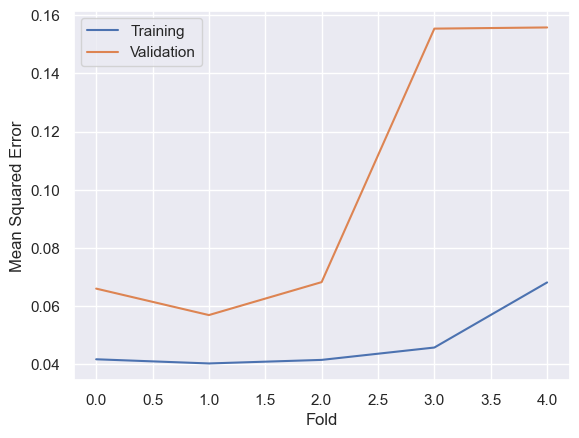

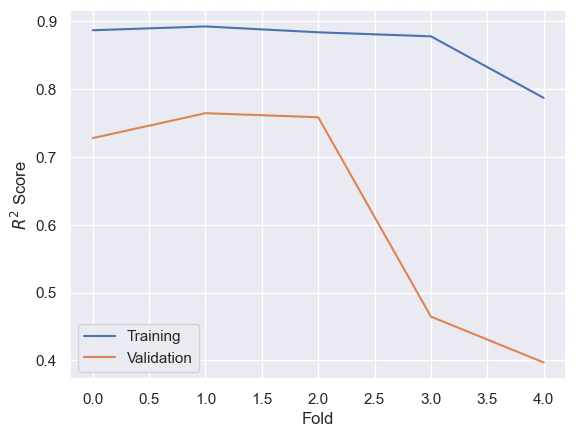

In [28]:
# Plot results per CV fold
plt.plot(-cv_results['train_neg_mean_absolute_error'], label='Training')
plt.plot(-cv_results['test_neg_mean_absolute_error'], label='Validation')
plt.xlabel('Fold')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

plt.plot(cv_results['train_r2'], label='Training')
plt.plot(cv_results['test_r2'], label='Validation')
plt.xlabel('Fold')
plt.ylabel('$R^2$ Score')
plt.legend()
plt.show()

Note that one might conclude that the model from the fold with the lowest error should be selected as the optimal solution. However, the model used at each fold is actually the same; the only difference is the training and validation datasets, which explains the differences in error metrics across the folds.

In [29]:
# Evaluate model fit using parameters from best CV fold
best_cv_model = cv_results['estimator'][2]
best_cv_model.fit(train, train['count'])

# Metrics check
print(f"Training R^2: {best_cv_model.score(train, train['count'])}")
print(f"Validation R^2: {best_cv_model.score(valid, valid['count'])}")
print(f"Training RMSE: {np.sqrt(mean_squared_error(train['count'], best_cv_model.predict(train)))}")
print(f"Validation RMSE: {np.sqrt(mean_squared_error(valid['count'], best_cv_model.predict(valid)))}")

Training R^2: 0.7612292257384539
Validation R^2: 0.40911600385808466
Training RMSE: 1538.1491956726748
Validation RMSE: 3949.1279234633384


### Modeling Noise: Moving Window Average
Next let's model the noise in the residuals of the drift + seasonality model. The goal is to find and model correlated noise which can be used to predict future noise. One common technique is the Moving Window or Rolling Window Average, in which the moving average of a time series data point in time is calculated over a window of *k* previous points.

In [30]:
# Compute residuals
train_residuals = (train['count'] - model_features.predict(train))
valid_residuals = (valid['count'] - model_features.predict(valid))

Let's plot autocorrelation. The solid and dashed lines represent 95% and 99% confidence levels, respectively, for the zero-correlation hypothesis. Note that autocorrelation is one at zero lag despite not being visible on the plot.

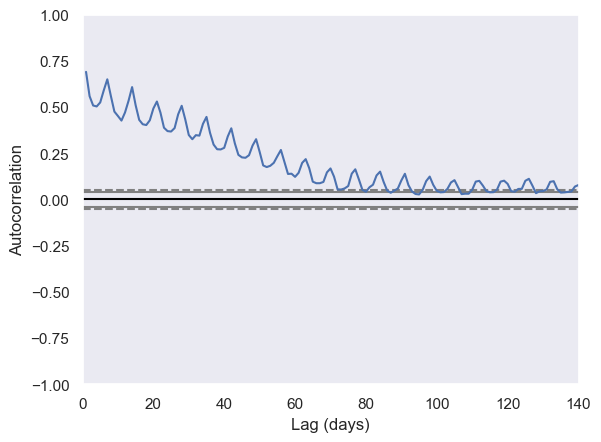

In [31]:
# Plot autocorrelation
autocorrelation_plot(train_residuals)
plt.xlabel('Lag (days)')
plt.xlim([0, 140]);

Autocorrelation drops within the confidence interval at around 80 days. Thus we should only consider noise up to 80 days prior when predicting future noise. This will be our window size in computing the moving average.

In [32]:
class MovingWindowAvg(base.BaseEstimator, base.TransformerMixin):
    """Generate features based on window statistics of past noise/residuals."""

    def __init__(self, window=80):
        self.window = window
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        '''Generate new features'''
        df = pd.DataFrame()
        df['residual'] = pd.Series(X, index=X.index)
        df['prior'] = df['residual'].shift(1)
        df['mean'] = df['residual'].rolling(window=self.window, min_periods=0).mean()
        df['diff'] = df['residual'].diff().rolling(window=self.window).mean()
        df = df.fillna(method='bfill')
        
        return df

How far into the future the model is able to forecast is a parameter that must be set. Let's try generating a model that predicts ridership demand 5 days into the future.

In [33]:
DAYS_INTO_FUTURE = 5

# Create and train residual model
residual_model = Pipeline([('residual_features', MovingWindowAvg(window=80)), 
                        ('regressor', Ridge())])

residual_model.fit(train_residuals.iloc[:-DAYS_INTO_FUTURE], 
                train_residuals.shift(-DAYS_INTO_FUTURE).dropna())

# Evaluate noise model
noise_pred = residual_model.predict(valid_residuals)
df_valid_noise = pd.Series(noise_pred, index=valid.index).to_frame(name='noise_pred')
df_valid_noise['target_noise'] = valid_residuals.shift(-DAYS_INTO_FUTURE)
df_valid_noise = df_valid_noise.dropna()
print(f"Residual validation set R^2: {r2_score(df_valid_noise['target_noise'], df_valid_noise['noise_pred'])}")

Residual validation set R^2: 0.50374006294133


In [48]:
class FullModel(base.BaseEstimator, base.RegressorMixin):
    """Complete model for drift, seasonlity, and noise"""
    
    def __init__(self, baseline, residual_model, steps=3):
        """Combine a baseline and residual model to predict any number of steps in the future."""
        self.baseline = baseline
        self.residual_model = residual_model
        self.steps = steps
        
    def fit(self, X, y):
        self.baseline.fit(X, y)
        resd = y - self.baseline.predict(X)
        self.residual_model.fit(resd.iloc[:-self.steps], resd.shift(-self.steps).dropna())
        # TODO does EWMA need steps input?
        # if self.steps != 0:
        #     self.residual_model.fit(resd.iloc[:-self.steps], resd.shift(-self.steps).dropna())
        # else:
        #     self.residual_model.fit(X, y)     
        return self
    
    def predict(self, X):
        y_b = pd.Series(self.baseline.predict(X), index=X.index)
        resd = X['count'] - y_b
        resd_pred = pd.Series(self.residual_model.predict(resd), index=X.index)
        resd_pred = resd_pred.shift(self.steps)
        y_pred = y_b + resd_pred
        
        return y_pred
    
# Construct and train full model
full_model = FullModel(model_features, residual_model, steps=DAYS_INTO_FUTURE)
full_model.fit(train, train['count'])
y_pred_train = full_model.predict(train)
print(f"Train R^2: {r2_score(train['count'].iloc[DAYS_INTO_FUTURE:], y_pred_train.dropna())}")

# Make predictions
y_pred_valid = full_model.predict(valid)
print(f"Validation R^2: {r2_score(valid['count'].iloc[DAYS_INTO_FUTURE:], y_pred_valid.dropna())}")

Train R^2: 0.8716684809602856
Validation R^2: 0.8169260200679541


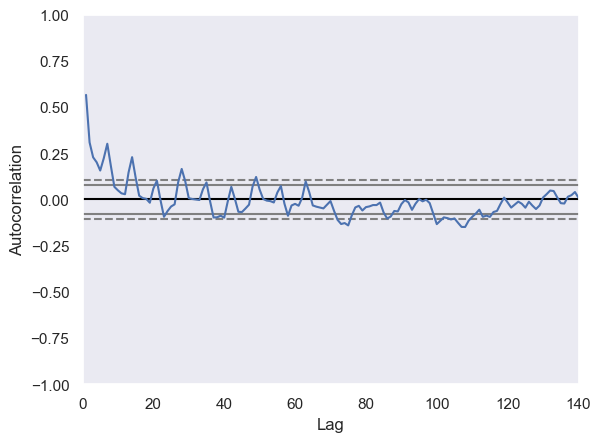

In [49]:
# Check autocorrelation plot again
resd = valid['count'].iloc[DAYS_INTO_FUTURE:] -  y_pred_valid.dropna()
autocorrelation_plot(resd)
plt.xlim([0, 140]);

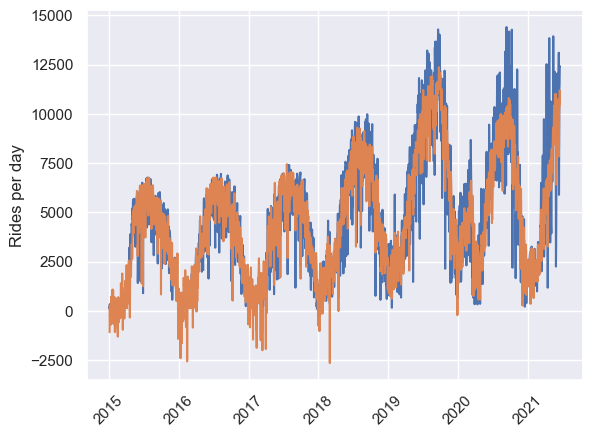

In [50]:
# Visualize fit on training data
plt.plot(train.index, train['count'], 
         train.index, full_model.predict(train));
plt.xticks(rotation=45);
plt.ylabel('Rides per day');

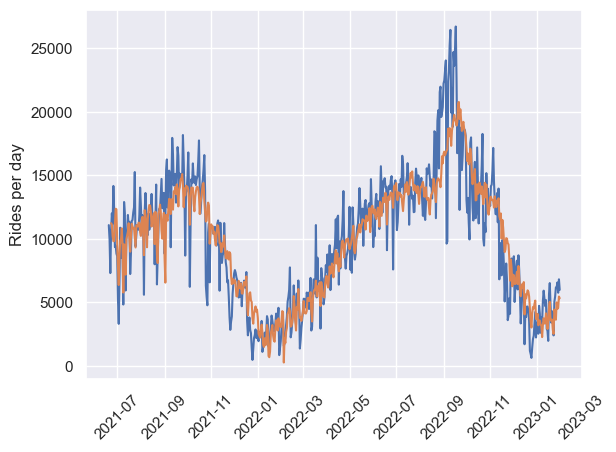

In [51]:
# Visualize fit on validation data
plt.plot(valid.index, valid['count'], valid.index, full_model.predict(valid));
plt.xticks(rotation=45);
plt.ylabel('Rides per day');

### Modeling Noise: Exponentially-Weighted Moving Average (EWMA)
Another simple windowing average techique is the exponentially-weighted moving average (EWMA). Here all data points are used in calculating the average, but are weighted with an exponential decay. Therefore more recent points contribute more to the moving average than points further in the past. A major benefit of EWMA is that the moving average can be calculated simply from the current time series data point and the previous moving average value.

In [52]:
class ExponentialMovingAvg(base.BaseEstimator, base.TransformerMixin):
    """Generate features based on window statistics of past noise/residuals."""

    def __init__(self, halflife=5):
        self.halflife = halflife
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        '''Generate new features'''
        df = pd.DataFrame()
        df['residual'] = pd.Series(X, index=X.index)
        df['previous'] = df['residual'].shift(1)
        df['rolling'] = df['residual'].ewm(halflife=self.halflife).mean().shift(1)
        df = df.fillna(method='bfill')
        
        return df

# Create and train residual model
residual_model = Pipeline([('residual_features', ExponentialMovingAvg(halflife=5)), 
                           ('regressor', Ridge())])

In [56]:
DAYS_INTO_FUTURE = 3

# TODO update FullModel so that EWMA doesn't need 'steps'
# Construct and train full model
full_model = FullModel(model_features, residual_model, steps=DAYS_INTO_FUTURE)
full_model.fit(train, train['count'])
y_pred_train = full_model.predict(train)
print(f"Train R^2: {r2_score(train['count'].iloc[DAYS_INTO_FUTURE:], y_pred_train.dropna())}")

# Make predictions
y_pred_valid = full_model.predict(valid)
print(f"Validation R^2: {r2_score(valid['count'].iloc[DAYS_INTO_FUTURE:], y_pred_valid.dropna())}")

# Save model
with open(Path('./assets/ewma_model.dill'), 'wb') as f:
    dill.dump(full_model, f)

Train R^2: 0.8716684809602856
Validation R^2: 0.8169260200679541


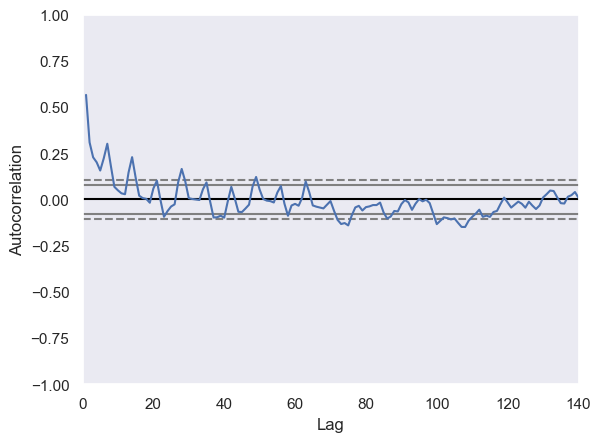

In [57]:
# Check autocorrelation plot again
resd = valid['count'].iloc[DAYS_INTO_FUTURE:] -  y_pred_valid.dropna()
autocorrelation_plot(resd)
plt.xlim([0, 140]);

The exponentially-weighted moving average approach appears to have a better $R^2$ score than the rolling window approach. More of the correlated noise was also able to be taken out as shown by the plot above. 

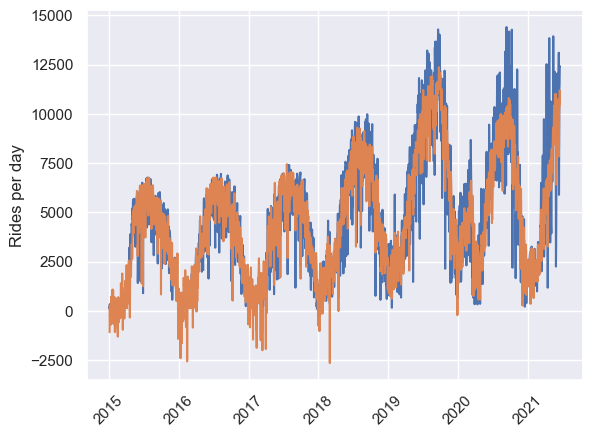

In [58]:
# Visualize results on training data
plt.plot(train.index, train['count'], 
         train.index, full_model.predict(train));
plt.xticks(rotation=45);
plt.ylabel('Rides per day');

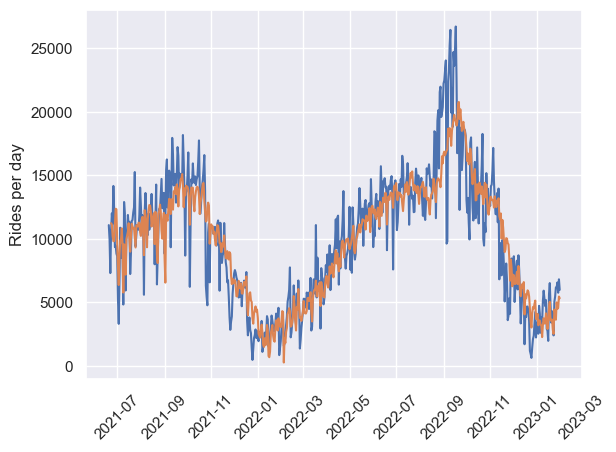

In [59]:
# Visualize fit on validation data
plt.plot(valid.index, valid['count'], valid.index, full_model.predict(valid));
plt.xticks(rotation=45);
plt.ylabel('Rides per day');